In [47]:
# Imports and styling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

plt.style.use('default')

In [48]:
# Initial dataset handling
"""
survival 	Survival 	            0 = No, 1 = Yes
pclass 	    Ticket class 	        1 = 1st, 2 = 2nd, 3 = 3rd
sex 	    Sex 	
Age 	    Age in years 	
sibsp 	    # of siblings / spouses aboard the Titanic 	
parch 	    # of parents / children aboard the Titanic 	
ticket 	    Ticket number 	
fare 	    Passenger fare 	
cabin 	    Cabin number 	
embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton
"""
df_train = pd.read_csv('input/train.csv', sep=',')
df_test = pd.read_csv('input/test.csv', sep=',')
ids_test = df_test["PassengerId"]

# Remove unusuable string parameters, plus cabin has many NaN values
df_train = df_train.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
df_test = df_test.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

# Map strings to numeric values
df_train["Sex"] = df_train["Sex"].map({"male": 0, "female": 1})
df_train["Embarked"] = df_train["Embarked"].map({"C": 0, "Q": 1, "S": 2})
df_test["Sex"] = df_test["Sex"].map({"male": 0, "female": 1})
df_test["Embarked"] = df_test["Embarked"].map({"C": 0, "Q": 1, "S": 2})

In [49]:
df_train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [50]:
df_test.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [51]:
# Fill in missing fare value
df_test["Fare"] = df_test["Fare"].replace(np.NaN, df_test["Fare"].mean())

# Fill in missing age values considering SibSp and Parch
age_cols = ["SibSp", "Parch", "Age"]
impute = IterativeImputer()

X_age = df_train[age_cols]
df_age = pd.DataFrame(np.round(impute.fit_transform(X_age)), columns=age_cols)
df_train["Age"] = df_age["Age"]

X_age = df_test[age_cols]
df_age = pd.DataFrame(np.round(impute.fit_transform(X_age)), columns=age_cols)
df_test["Age"] = df_age["Age"]

# Remove rows with negative ages
df_train["Age"] = df_train[df_train["Age"] >= 0]["Age"]

# Remove rows with empty embarked values from the training data
df_train = df_train.dropna().reset_index(drop=True)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2.0
1,1,1,1,38.0,1,0,71.2833,0.0
2,1,3,1,26.0,0,0,7.9250,2.0
3,1,1,1,35.0,1,0,53.1000,2.0
4,0,3,0,35.0,0,0,8.0500,2.0


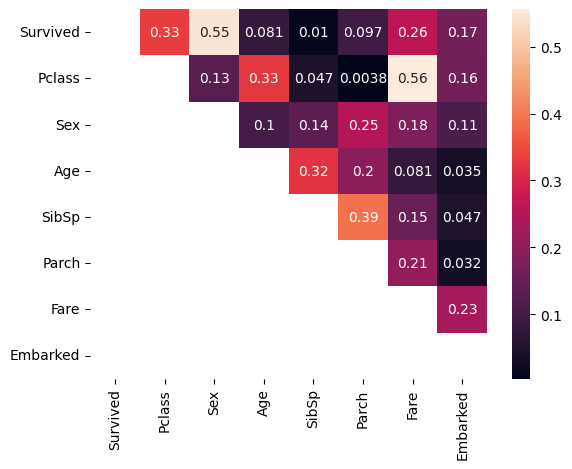

Age      0.080560
SibSp    0.010423
Parch    0.097486
Name: Survived, dtype: float64

In [52]:
# Correlation matrix to check for unusable values
corr_matrix = df_train.corr()
upper_tri = abs(corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))
plt.figure()
sns.heatmap(upper_tri, annot=True)
plt.show()

cor_target = abs(corr_matrix["Survived"])
to_drop = cor_target[cor_target < 0.1]
to_drop

In [53]:
bins = [-0.1, 9, 15, 24, 59, 80]
group_names = [0, 1, 2, 3, 4]

"""
child -  0 to  9 years
teen  - 10 to 15 years
young - 16 to 24 years
adult - 25 to 59 years
elder - 60 to 80 years
"""

df_train["Age"] = pd.to_numeric(pd.cut(df_train["Age"], bins, labels=group_names))

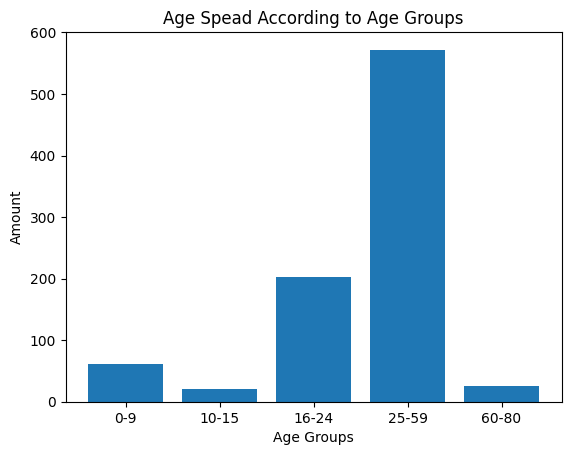

In [54]:
labels = df_train["Age"].unique()
values = df_train["Age"].value_counts().sort_index()

plt.bar(["0-9", "10-15", "16-24", "25-59", "60-80"], values)
plt.title("Age Spead According to Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Amount")
plt.show()

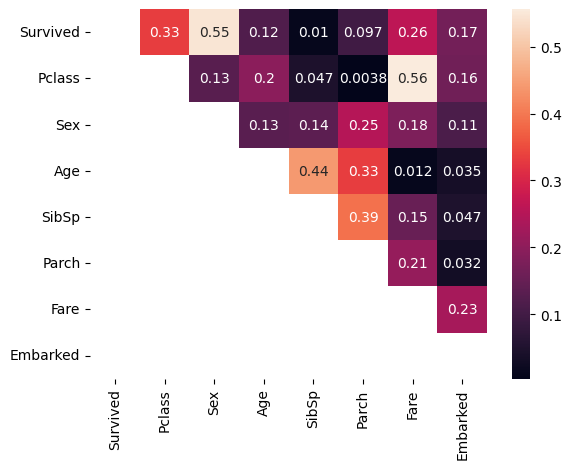

SibSp    0.010423
Parch    0.097486
Name: Survived, dtype: float64

In [55]:
# Correlation matrix to check for unusable values
corr_matrix = df_train.corr()
upper_tri = abs(corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))
plt.figure()
sns.heatmap(upper_tri, annot=True)
plt.show()

cor_target = abs(corr_matrix["Survived"])
to_drop = cor_target[cor_target < 0.1]
to_drop

In [56]:
# SibSp, Parch and Age have low correlation with the output parameter, so they're also removed
df_train = df_train.drop(["SibSp", "Parch"], axis=1)
df_test = df_test.drop(["SibSp", "Parch"], axis=1)

In [57]:
# Normalize data
survived_train = df_train["Survived"]

scaled_df_train = pd.DataFrame(normalize(df_train, axis=0), columns=df_train.columns)
scaled_df_test = pd.DataFrame(normalize(df_test, axis=0), columns=df_test.columns)
df_train = scaled_df_train
df_test = scaled_df_test
df_train["Survived"] = survived_train

In [58]:
X_train = df_train.drop(["Survived"], axis=1)
y_train = df_train["Survived"]
df_submission = df_test

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=24)

In [60]:
clf = DecisionTreeClassifier()
path = clf.cost_complexity_pruning_path(X_train, y_train)

Text(0, 0.5, 'total impurity of leaves')

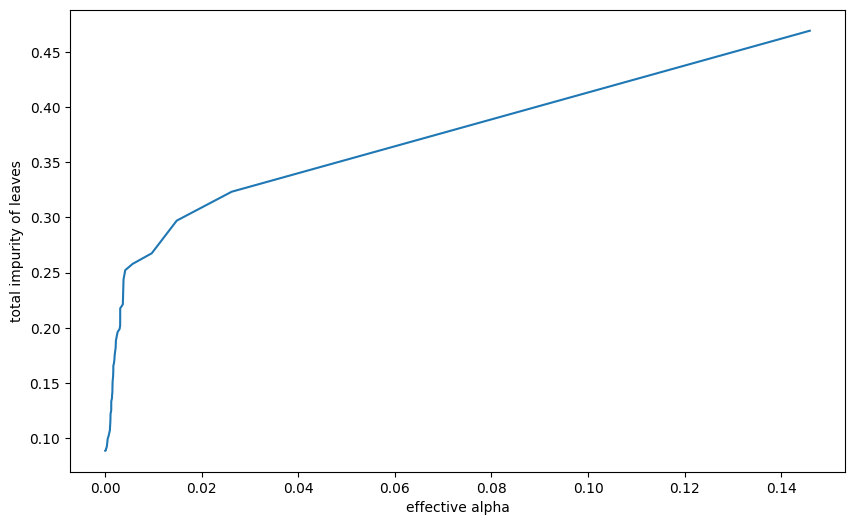

In [61]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

In [62]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

Text(0, 0.5, 'total depth')

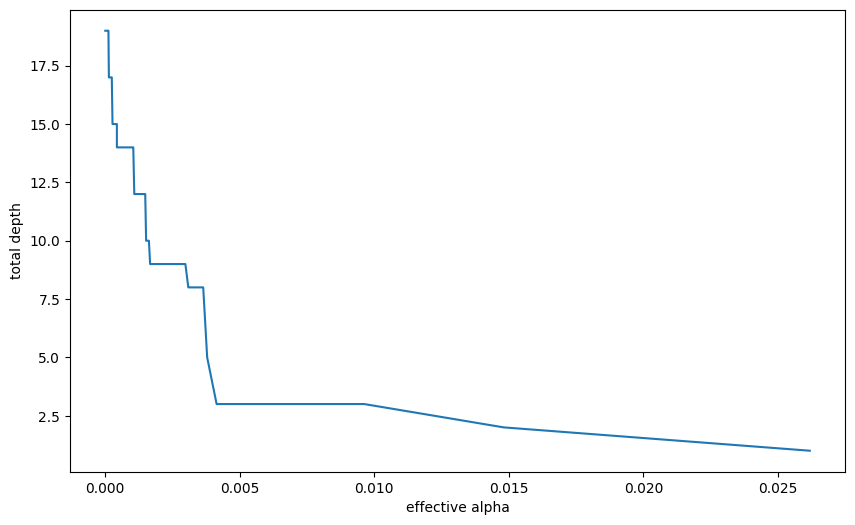

In [63]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")

Text(0, 0.5, 'Accuracy scores')

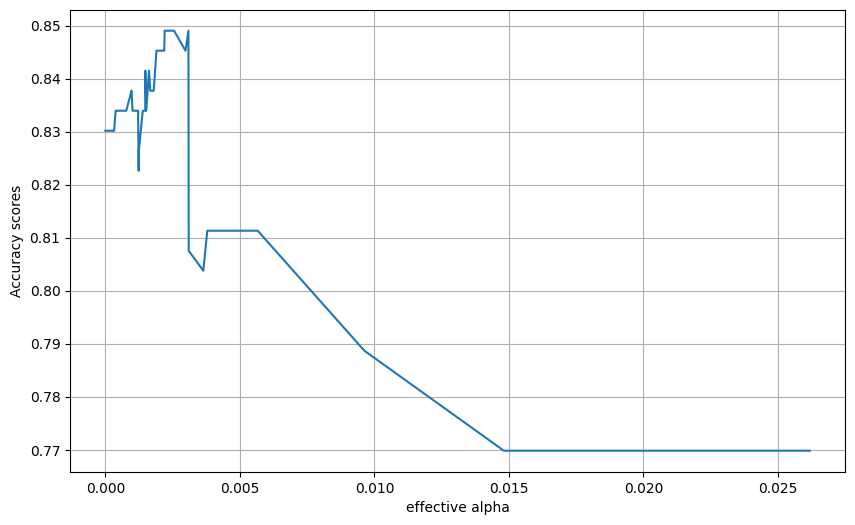

In [64]:
acc_scores = [accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Accuracy scores")

In [65]:
cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(df_test))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(max_depth=depth)
    for train_fold, valid_fold in cv.split(df_train):
        f_train = df_train.loc[train_fold]
        f_valid = df_train.loc[valid_fold]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(f_valid.drop(["Survived"], axis=1), f_valid["Survived"])
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy) / len(fold_accuracy)
    accuracies.append(avg)

df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.787921
         2          0.787921
         3          0.823110
         4          0.820825
         5          0.840092


In [66]:
dt = DecisionTreeClassifier(ccp_alpha=0.0024).fit(X_train, y_train)

training_score = dt.score(X_train, y_train)
print("Training set score: {:.4f}".format(training_score))

Training set score: 0.8752


In [67]:
prediction = dt.predict(df_submission)

In [68]:
output = pd.DataFrame({"PassengerId" : ids_test, "Survived": prediction})
output.to_csv("submission.csv", index=False)

[Text(0.6018518518518519, 0.95, 'X[1] <= 0.028\ngini = 0.469\nsamples = 617\nvalue = [385, 232]'),
 Text(0.35185185185185186, 0.85, 'X[3] <= 0.015\ngini = 0.299\nsamples = 409\nvalue = [334, 75]'),
 Text(0.2777777777777778, 0.75, 'X[2] <= 0.006\ngini = 0.209\nsamples = 295\nvalue = [260, 35]'),
 Text(0.24074074074074073, 0.65, 'gini = 0.219\nsamples = 8\nvalue = [1, 7]'),
 Text(0.3148148148148148, 0.65, 'gini = 0.176\nsamples = 287\nvalue = [259, 28]'),
 Text(0.42592592592592593, 0.75, 'X[3] <= 0.015\ngini = 0.456\nsamples = 114\nvalue = [74, 40]'),
 Text(0.3888888888888889, 0.65, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.46296296296296297, 0.65, 'X[3] <= 0.03\ngini = 0.44\nsamples = 110\nvalue = [74, 36]'),
 Text(0.37037037037037035, 0.55, 'X[3] <= 0.022\ngini = 0.371\nsamples = 65\nvalue = [49, 16]'),
 Text(0.3333333333333333, 0.45, 'X[0] <= 0.021\ngini = 0.449\nsamples = 47\nvalue = [31, 16]'),
 Text(0.18518518518518517, 0.35, 'X[4] <= 0.02\ngini = 0.495\nsamples = 29\nval

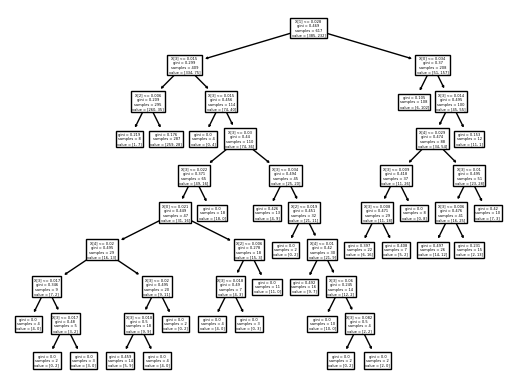

In [69]:
plot_tree(dt)